<a href="https://colab.research.google.com/github/shinjinisen/cryptocurrency-prediction/blob/main/cryptocurrency_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [1]:
import numpy as n
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as p
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

Data preprocessing

In [3]:
# Importing data and rectifying loss of data by filling the NaN values with mean of the whole field
data = p.read_csv('/content/sample_data/LTC-USD.csv', date_parser=True)
count = 0
for j in data['Open']:
  if(math.isnan(j)):
    count+=1
data['Open'].fillna(value=data['Open'].mean(), inplace=True)
data['High'].fillna(value=data['High'].mean(), inplace=True)
data['Low'].fillna(value=data['Low'].mean(), inplace=True)
data['Close'].fillna(value=data['Close'].mean(), inplace=True)
data['Adj Close'].fillna(value=data['Adj Close'].mean(), inplace=True)
data['Volume'].fillna(value=data['Volume'].mean(), inplace=True)
print(f"Number of empty tuples in imported dataset: {count}")

Number of empty tuples in imported dataset: 4


<ipython-input-3-a102b8a90c00>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = p.read_csv('/content/sample_data/LTC-USD.csv', date_parser=True)


In [5]:
# Splitting data into traing and test data and dropping all the unnecessay columns from the table
training_data = data[data['Date'] <= '2021-10-31'].copy()
test_data = data[data['Date'] > '2021-10-31'].copy()

training_data = training_data.drop(['Date', 'Adj Close'], axis=1)

Feature Scaling

In [6]:
# Scaling the data to fit a particular range
scaler = MinMaxScaler()
train_data = scaler.fit_transform(training_data)
X_train = []
Y_train = []

for i in range(60, train_data.shape[0]):
    X_train.append(train_data[i - 60:i])
    Y_train.append(train_data[i, 0])

X_train = n.array(X_train)
Y_train = n.array(Y_train)

Building the model

In [7]:

# Creating multiple layers of neural network
model = Sequential()
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           98816     
                                                                 
 dropout_2 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               1

Fitting of model

In [8]:
# Training the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
72/72 [==============================] - 29s 336ms/step - loss: 0.0066 - val_loss: 0.0205
Epoch 2/50
72/72 [==============================] - 16s 221ms/step - loss: 0.0026 - val_loss: 0.0190
Epoch 3/50
72/72 [==============================] - 16s 222ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 4/50
72/72 [==============================] - 16s 220ms/step - loss: 0.0018 - val_loss: 0.0129
Epoch 5/50
72/72 [==============================] - 17s 232ms/step - loss: 0.0016 - val_loss: 0.0083
Epoch 6/50
72/72 [==============================] - 17s 233ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 7/50
72/72 [==============================] - 19s 263ms/step - loss: 0.0012 - val_loss: 0.0159
Epoch 8/50
72/72 [==============================] - 20s 282ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 9/50
72/72 [==============================] - 17s 234ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 10/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0010 - val_lo

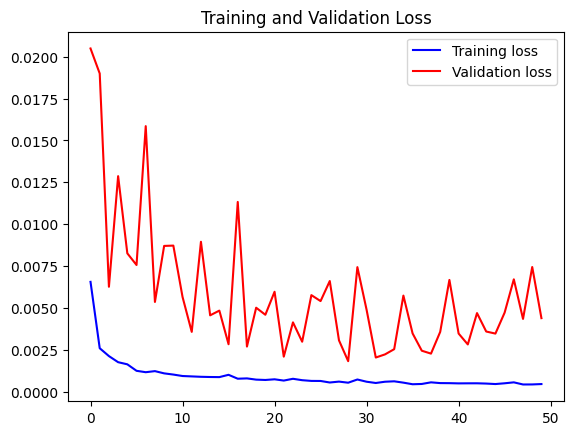

In [9]:
# Calculating the loss and validation loss and plotting a graph to compare them
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [15]:
# Creating a test data to predict the trend of the market before 60 days
part_60_days = training_data.tail(60)
df = p.concat([part_60_days, test_data], ignore_index=True)
df = df.drop(['Date', 'Adj Close'], axis=1)
df.head()
inputs = scaler.transform(df)

X_test = []
Y_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    Y_test.append(inputs[i, 0])

X_test = np.array(X_test)
Y_test = np.array(Y_test)

Predicting and plotting the output

In [16]:
# Scaling the data for plotting the final graph
Y_pred = model.predict(X_test)

scale = 1/scaler.scale_[0]
Y_test = Y_test*scale
Y_pred = Y_pred*scale


1/1 [==============================] - 1s 929ms/step


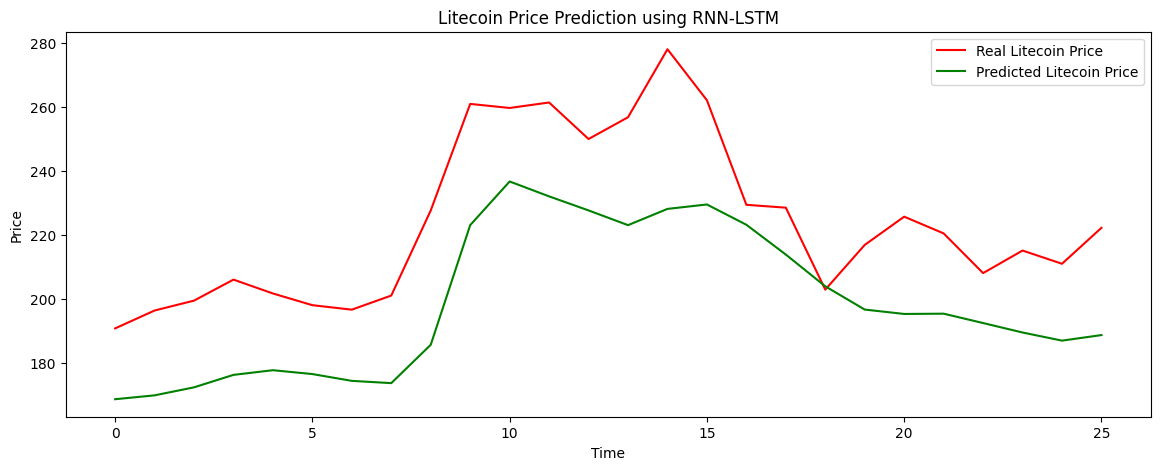

In [17]:

# Plotting the final graph to predict the trend of the market
plt.figure(figsize=(14, 5))
plt.plot(Y_test, color='red', label='Real Litecoin Price')
plt.plot(Y_pred, color='green', label='Predicted Litecoin Price')
plt.title('Litecoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
